In [13]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from pylab import *
import os
import pickle
import pandas as pd
import numpy as np
from paretoset import paretoset
import torch

import loss_landscapes
import loss_landscapes.metrics

# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

In [15]:
model = rn08.RN08(True, [4, 4, 7], 0.0015625)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model(torch.randn((1,3,32,32)).to(device))  # Update tensor shapes 
print(model)
try:
    model_param = torch.load("/data/tbaldi/work/loss_landscape_taxonomy/workspace/models/rn08/net_full_precision_best.ckpt", 
                             map_location=device)
    model.load_state_dict(model_param['state_dict'])
except:
    print(f"File not found! ({model_file})")
# get the accuracy

model


RN08(
  (model): QResNet(
    (quant_relu): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 4.29)
    (quant_input): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: -3.49, Act_max: 4.15)
    (conv1): (QuantBnConv2d(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
    ), weight_bit=4, bias_bit=4, groups=1, wt-channel-wise=True, wt-percentile=0, quant_mode=symmetric)
    (QBlocks): Sequential(
      (0): QBlock(
        (quant_relu1): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 3.97)
        (quant_relu2): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 3.85)
        (quant_relu3): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, A

RN08(
  (model): QResNet(
    (quant_relu): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 1.35)
    (quant_input): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: -1.99, Act_max: 2.13)
    (conv1): (QuantBnConv2d(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
    ), weight_bit=4, bias_bit=4, groups=1, wt-channel-wise=True, wt-percentile=0, quant_mode=symmetric)
    (QBlocks): Sequential(
      (0): QBlock(
        (quant_relu1): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.61)
        (quant_relu2): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 1.18)
        (quant_relu3): QuantAct(activation_bit=7, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, A

In [16]:
_, dataloader, _, = rn08.get_cifar10_loaders("/data/tbaldi/work/loss_landscape_taxonomy/data/RN08", 1024)

criterion = model.loss
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x, y)
loss_data = loss_landscapes.random_plane(model,
                                         metric,
                                         100,
                                         40,
                                         normalization="filter",
                                         deepcopy_model=False)

Files already downloaded and verified
Dataset Size:
48 5 3


/tmp/tbaldi/ipykernel_1013383/2473547062.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


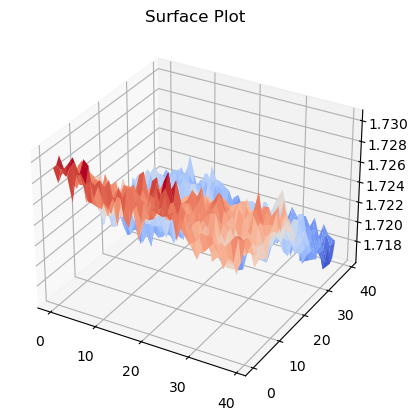

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(40)] for i in range(40)])
Y = np.array([[i for _ in range(40)] for i in range(40)])
ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_title(f'Surface Plot')
fig.show()

# Models Training Status

In this notebook there are scripts to check which models are there and which are missing.

In [ ]:
base_path = "/home/jovyan/checkpoint/"
sizes = ['small', 'baseline', 'large']
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
missing = []
def get_missing_econ(bs, lr, precision):
    missing = []
    for size in sizes:
        # print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
        for exp in range(1, 4):
            file_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_{exp}.txt'
            try:
                with open(file_path, 'r') as file:
                    content = file.read()

            except Exception as e:
                if size == 'large':
                    missing.append((bs, lr, precision))
                    continue
    return set(missing)


In [ ]:
missing = {}
for bs in batch_sizes:
    
    print(f'=========== {bs} ==========')
    for lr in learning_rates:
        print(f'---------- {lr} ---------')
        for precision in precisions:
            mis = get_missing_econ(bs, lr, precision)
            if mis:
                print(f'{bs} - {lr} - {precision}')
            

=========== 16 ==========
---------- 0.1 ---------
---------- 0.05 ---------
---------- 0.025 ---------
---------- 0.0125 ---------
---------- 0.00625 ---------
---------- 0.003125 ---------
16 - 0.003125 - 2
---------- 0.0015625 ---------
=========== 32 ==========
---------- 0.1 ---------
---------- 0.05 ---------
---------- 0.025 ---------
---------- 0.0125 ---------
---------- 0.00625 ---------
---------- 0.003125 ---------
---------- 0.0015625 ---------
=========== 64 ==========
---------- 0.1 ---------
---------- 0.05 ---------
---------- 0.025 ---------
---------- 0.0125 ---------
---------- 0.00625 ---------
---------- 0.003125 ---------
---------- 0.0015625 ---------
64 - 0.0015625 - 8
=========== 128 ==========
---------- 0.1 ---------
---------- 0.05 ---------
---------- 0.025 ---------
---------- 0.0125 ---------
---------- 0.00625 ---------
---------- 0.003125 ---------
---------- 0.0015625 ---------
=========== 256 ==========
---------- 0.1 ---------
---------- 0.05 ------

In [ ]:
missing = []
def get_missing_econ(bs, lr, precision):
    missing = []
    for size in sizes:
        # print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
        for exp in range(1, 6):
            file_path = base_path + f'bs{bs}_lr{lr}/JTAG_{precision}b/accuracy_{exp}.txt'
            try:
                with open(file_path, 'r') as file:
                    content = file.read()

            except Exception as e:
                missing.append((bs, lr, precision))
                continue
    return set(missing)

In [ ]:
missing = {}
for bs in batch_sizes:
    
    print(f'=========== {bs} ==========')
    for lr in learning_rates:
        print(f'---------- {lr} ---------')
        for precision in precisions:
            mis = get_missing_econ(bs, lr, precision)
            if mis:
                print(f'{bs} - {lr} - {precision}')

=========== 16 ==========
---------- 0.1 ---------
16 - 0.1 - 2
---------- 0.05 ---------
16 - 0.05 - 2
---------- 0.025 ---------
16 - 0.025 - 2
---------- 0.0125 ---------
16 - 0.0125 - 2
---------- 0.00625 ---------
16 - 0.00625 - 2
---------- 0.003125 ---------
16 - 0.003125 - 2
---------- 0.0015625 ---------
16 - 0.0015625 - 2
=========== 32 ==========
---------- 0.1 ---------
32 - 0.1 - 2
---------- 0.05 ---------
32 - 0.05 - 2
---------- 0.025 ---------
32 - 0.025 - 2
---------- 0.0125 ---------
32 - 0.0125 - 2
---------- 0.00625 ---------
32 - 0.00625 - 2
---------- 0.003125 ---------
32 - 0.003125 - 2
---------- 0.0015625 ---------
32 - 0.0015625 - 2
=========== 64 ==========
---------- 0.1 ---------
64 - 0.1 - 2
---------- 0.05 ---------
64 - 0.05 - 2
---------- 0.025 ---------
64 - 0.025 - 2
---------- 0.0125 ---------
64 - 0.0125 - 2
---------- 0.00625 ---------
64 - 0.00625 - 2
---------- 0.003125 ---------
64 - 0.003125 - 2
---------- 0.0015625 ---------
64 - 0.0015625 - 